In [1]:
import os
import shutil
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import geopandas as gpd

from eumap.mapper import SpaceOverlay, SpaceTimeOverlay
from eumap.misc import find_files

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('/mnt/inca/tillage_index/data/013_vld_edlinger.csv')

In [2]:
# url = ['http://192.168.1.30:8333/ai4sh/bs/bs_glad.landsat.seasconv.m.yearly_sum_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127.tif']

# urls = []
# for i in url:
#     if '{oper}' in i:
#         for j in ['p25','p50','p75']:
#             urls.append(i.replace('{oper}',j))
#     if '{year}' in i:
#         for j in np.arange(2007,2017,1):
#             urls.append(i.replace('{year}',str(j)))
        
# urls = [Path(i) for i in urls]

# points = '/mnt/inca/tillage_index/validate_data/swiss_share_points/validate_biodiversa_network_point_epsg3035.gpkg'
# spc_overlay = SpaceOverlay(points, fn_layers=urls, verbose=True)
# data = spc_overlay.run()

# cols = data.columns.values.tolist()
# cols.sort()
# bsf_cols = [i for i in cols if 'bs_glad' in i]
# data['bsf_10years'] = data.apply(lambda row: [row[col] for col in bsf_cols], axis=1)
# data['bsf_10years_agg'] = data['bsf_10years'].apply(lambda x: np.mean(x))
# data.to_csv('/mnt/inca/tillage_index/validate_data/007_vld_edlinger.csv', index=False)

[09:35:03] 1/10 bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20090101_20091231_eu_epsg.3035_v20231127
[09:35:03] 2/10 bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20080101_20081231_eu_epsg.3035_v20231127
[09:35:03] 3/10 bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20120101_20121231_eu_epsg.3035_v20231127
[09:35:03] 4/10 bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20150101_20151231_eu_epsg.3035_v20231127
[09:35:03] 5/10 bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20100101_20101231_eu_epsg.3035_v20231127
[09:35:03] 6/10 bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20160101_20161231_eu_epsg.3035_v20231127
[09:35:03] 7/10 bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20140101_20141231_eu_epsg.3035_v20231127
[09:35:03] 8/10 bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20070101_20071231_eu_epsg.3035_v20231127
[09:35:03] 9/10 bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20110101_20111231_eu_epsg.3035_v20231127
[09:35:03] 10/10 bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20130101_20131231_eu_epsg.3035

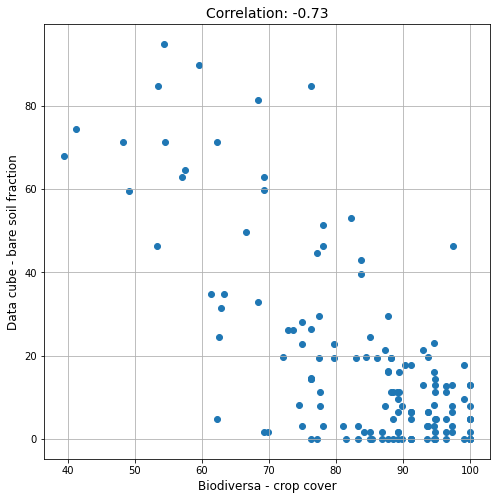

In [3]:
import matplotlib.pyplot as plt
import numpy as np

correlation = np.corrcoef(data['Crop_cover']*100, data['bsf_10years_agg'])[0, 1]

plt.figure(figsize=(8, 8))
plt.scatter(data['Crop_cover']*100,data['bsf_10years_agg'])

plt.title(f'Correlation: {correlation:.2f}',fontsize=14)
plt.xlabel('Biodiversa - crop cover', fontsize=12)
plt.ylabel('Data cube - bare soil fraction', fontsize=12)

plt.grid()
# plt.legend()
plt.show()


In [4]:
# remove 2 points in the town, obvious deviation from ground truth
a = data.loc[(data['Crop_cover']<0.6) & (data['bsf_10years_agg']==0)]
a = a.drop(columns=['bsf_10years'])
# a.to_file('/mnt/inca/tillage_index/validate_data/swiss_share_points/weird_biodiversa_epsg.3035.gpkg',driver='GPKG')
a[['Crop_cover','bsf_10years_agg','tillage_intensity','Land_use']]

,Crop_cover,bsf_10years_agg,tillage_intensity,Land_use


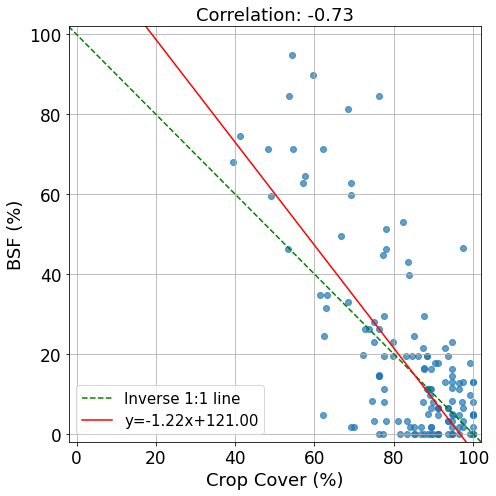

In [22]:
datar = data
# datar = data.loc[~((data['Crop_cover']<0.6) & (data['bsf_10years_agg']==0))]
# datar.to_csv('001_vld_biodiversa.csv')
x = datar['Crop_cover']*100
y = datar['bsf_10years_agg']

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Linear regression analysis with the adjusted data
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
y_pred = model.predict(np.array([-5, 105]).reshape(-1, 1))
# y_pred = model.predict(x.values.reshape(-1, 1))

# Calculate correlation with the adjusted data
correlation = np.corrcoef(x, y)[0, 1]

# Creating an enhanced plot with the adjustments
plt.figure(figsize=(7, 7))
plt.plot([-2, 102], [102, -2], color='green', linestyle='dashed', label='Inverse 1:1 line')
plt.plot([-2,102], y_pred, color='red', label=f'y={model.coef_[0][0]:.2f}x+{model.intercept_[0]:.2f}')
plt.scatter(x, y, alpha=0.7)


plt.title(f'Correlation: {correlation:.2f}', fontsize=18)
plt.xlabel('Crop Cover (%)', fontsize=18)
plt.ylabel('BSF (%)', fontsize=18)
plt.xlim([-2,102])
plt.ylim([-2,102])

plt.tick_params(labelsize=17)
plt.grid(True)

plt.legend(fontsize=15, loc='lower left')
plt.tight_layout()
plt.savefig('/mnt/inca/tillage_index/qgis_visualization/09_vld_bsf.png')

In [6]:
data.columns

Index(['Country', 'Lat', 'Long', 'Sample_ID', 'Plot_ID', 'tillage_intensity',
       'tillage_intensity_calc', 'Crop_sp_2017', 'Crop_2017', 'Land_use',
       'tillage_no_times', 'tillage_depth_max_cm', 'Crop_cover', 'src',
       'geometry', 'overlay_id',
       'bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20090101_20091231_eu_epsg.3035_v20231127',
       'bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20080101_20081231_eu_epsg.3035_v20231127',
       'bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20120101_20121231_eu_epsg.3035_v20231127',
       'bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20150101_20151231_eu_epsg.3035_v20231127',
       'bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20100101_20101231_eu_epsg.3035_v20231127',
       'bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20160101_20161231_eu_epsg.3035_v20231127',
       'bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20140101_20141231_eu_epsg.3035_v20231127',
       'bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20070101_20071231_eu_epsg.

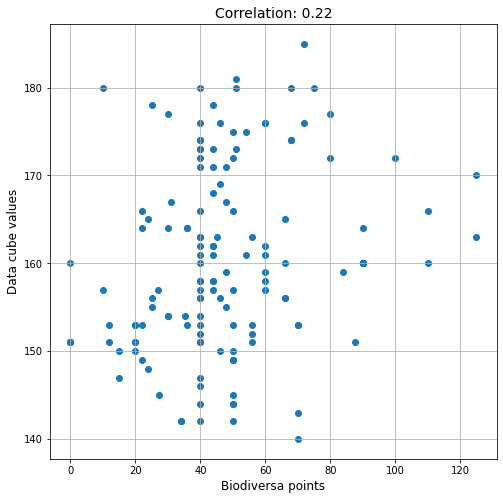

In [48]:
import matplotlib.pyplot as plt
import numpy as np

correlation = np.corrcoef(data['tillage_intensity_calc'], data['ndti_glad.landsat.seasconv.m.yearly_p50_30m_s_20160101_20161231_eu_epsg.3035_v20231127'])[0, 1]

plt.figure(figsize=(8, 8))
plt.scatter(data['tillage_intensity_calc'], data['ndti_glad.landsat.seasconv.m.yearly_p50_30m_s_20160101_20161231_eu_epsg.3035_v20231127'])

plt.title(f'Correlation: {correlation:.2f}',fontsize=14)
plt.xlabel('Biodiversa points', fontsize=12)
plt.ylabel('Data cube values', fontsize=12)

plt.grid()
# plt.legend()
plt.show()

In [ ]:
### mask, calculate zonal statistics each NUTS2 region, correlate, tillage

In [ ]:
### show case the necessaity of 30m resolution dataet, farm land, NOS CDR